In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%matplotlib inline
import pickle
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [3]:
%cd drive/My\ Drive

/content/drive


In [ ]:
%cd SiameseNets-experiments/

In [6]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [7]:
class Config():
    training_dir = "./data/rg-balanced/train/"
    testing_dir = "./data/rg-balanced/val/"
    custom_testing_dir = "./data/rg-balanced/custom_testing/test"
    custom_labeled_dir = "./data/rg-balanced/custom_testing/labeled"
    train_batch_size = 64
    train_number_epochs = 20

In [8]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
#                 print(img1_tuple[0])
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
#         print(img0)
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
#         print(img0)
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [9]:
class SiameseNetworkDatasetMyTest(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]#random.choice(self.imageFolderDataset.imgs)
#         print("Image tuple 0 : ",img0_tuple)
        img0 = Image.open(img0_tuple[0])
        img0 = img0.convert("L")
        if self.transform is not None:
            img0 = self.transform(img0)        
        return img0, torch.from_numpy(np.array([int(img0_tuple[1])],dtype=np.int32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [10]:
class SiameseNetworkDatasetMyLabel(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]#random.choice(self.imageFolderDataset.imgs)
#         print("Label: ",img0_tuple, img0_tuple[1])
        img0 = Image.open(img0_tuple[0])
        img0 = img0.convert("L")
        if self.transform is not None:
            img0 = self.transform(img0)        
        return img0, torch.from_numpy(np.array([int(img0_tuple[1])],dtype=np.int32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)



In [11]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [12]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.CenterCrop((50,50)),
                                                                      transforms.ToTensor(),
#                                                                       transforms.Normalize((0.5), (0.5))
                                                                      ])
                                       ,should_invert=False)

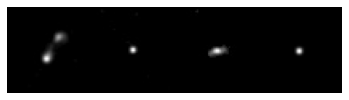

(2, 1, 50, 50)


In [13]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=2)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[1].numpy().shape)


In [14]:


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*50*50, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 4))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2=None):
        output1 = self.forward_once(input1)
        if input2 is None:
          return output1
        output2 = self.forward_once(input2)
        return output1, output2



In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [18]:
net = SiameseNetwork()
net.to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [19]:
counter = []
loss_history = [] 
iteration_number= 0


Epoch number 0
 Current loss 1.535538673400879

Epoch number 0
 Current loss 0.7785950303077698

Epoch number 0
 Current loss 0.6384725570678711

Epoch number 1
 Current loss 0.6142445802688599

Epoch number 1
 Current loss 0.829912543296814

Epoch number 1
 Current loss 0.6562427282333374

Epoch number 2
 Current loss 0.5074901580810547

Epoch number 2
 Current loss 0.4253218472003937

Epoch number 2
 Current loss 0.6422855257987976

Epoch number 3
 Current loss 0.49142909049987793

Epoch number 3
 Current loss 0.5528755187988281

Epoch number 3
 Current loss 0.3719410300254822

Epoch number 4
 Current loss 0.3466765284538269

Epoch number 4
 Current loss 0.306918740272522

Epoch number 4
 Current loss 0.3084432780742645

Epoch number 5
 Current loss 0.2633016109466553

Epoch number 5
 Current loss 0.23517654836177826

Epoch number 5
 Current loss 0.2814372479915619

Epoch number 6
 Current loss 0.28428491950035095

Epoch number 6
 Current loss 0.18068808317184448

Epoch number 6
 Cur

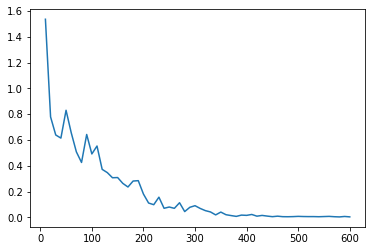

In [20]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [21]:
torch.save(net, 'siam-2.pth')

In [22]:
folder_dataset_test = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDatasetMyTest(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.CenterCrop((50,50)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
dataloader = DataLoader(siamese_dataset,num_workers=1,batch_size=1,shuffle=False)
dataiter = iter(dataloader)
# print(len(dataloader))
training_embedding = []
for i in range(len(dataloader)):
  x0,label_test= next(dataiter)
  label_test = label_test.cuda()
  label_test = (label_test.tolist())[0][0]
  x0 = x0.cuda() 
  output1 = net(Variable(x0))
  training_embedding.append([output1.cpu().detach().numpy().tolist()[0],label_test])
# print(training_embedding)
with open('train_embedding_newb.pkl','wb') as f:
  pickle.dump(training_embedding, f)
  
with open('train_embedding_newb.pkl','rb') as f:
  l = pickle.load(f)

In [24]:
with open('train_embedding_newb.pkl','rb') as f:
  l = pickle.load(f)

In [25]:
a = np.array(l[0][0])
b = np.array(l[1][0])

dist = np.linalg.norm(a-b)
print(dist)

0.12613015398943636


In [26]:
k = 50

In [27]:
import operator
def getResponse(neighbors):
	  classVotes = {}
#     print(neighbors)
	  for x in range(len(neighbors)):
		  response = neighbors[x][1]
		  if response in classVotes:
			  classVotes[response] += 1
		  else:
			  classVotes[response] = 1
	  sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
	  return sortedVotes[0][0]

In [28]:
folder_dataset_test = dset.ImageFolder(root=Config.custom_testing_dir)
# folder_dataset_label = dset.ImageFolder(root=Config.custom_labeled_dir)
siamese_dataset = SiameseNetworkDatasetMyTest(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.CenterCrop((50,50)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=False)
test_len = len(test_dataloader)
print(test_len)
test_dataiter = iter(test_dataloader)
y_true = []
prediction = []
correct = 0
for i in tqdm(range(test_len)):
    x0,label_test= next(test_dataiter)
    label_test = label_test.cuda()
    label_test = (label_test.tolist())[0][0]
    x0 = x0.cuda()
    test_embedding = net(Variable(x0))
    test_embedding = test_embedding.cpu().detach().numpy()
    dist_list = [] 
    label_list = []
    for j in range(len(l)):
      train_embedding = l[j][0]
      train_embedding = np.array(train_embedding)
      train_label = l[j][1]
      dist = np.linalg.norm(test_embedding-train_embedding)      
      dist_list.append(dist)
      label_list.append(train_label)
#     print(dist_list, label_list)
    zipped = zip(dist_list, label_list) 
    # Converting to list 
    zipped = list(zipped) 
    # Using sorted and lambda 
    final_list = sorted(zipped, key = lambda x: x[0]) 
    
    predicted_label = getResponse(final_list[0:k])
#     print(predicted_label, label_test)
    if predicted_label == label_test:
        correct += 1
    prediction.append(predicted_label)
    y_true.append(label_test)
# print(len(y_true), len(prediction))    
accuracy = correct*100.0/test_len
print(accuracy)

  0%|          | 0/404 [00:00<?, ?it/s]

404


100%|██████████| 404/404 [02:10<00:00,  3.09it/s]

74.25742574257426


In [29]:
confusion_matrix(y_true, prediction)



array([[47,  1, 34, 21],
       [ 0, 89,  9,  2],
       [ 6,  0, 89,  5],
       [24,  0,  2, 75]])

In [ ]:
print(len(y_true),prediction)
